In [1]:
"""
################################################################################

This file is p398dlp_read_audio.py. It will call a function in the file
p398dlp_read_audio_function.py. 

Read an audio binary file written by an Arduino Mega 2560 using the Arduino 
program sound_record.io. If desired, write a wav formatted version of the file.

George Gollin, University of Illinois, September 19, 2018

The binary audio file format written by the Arduino for 10-bit ADC data follows.
An unsigned long is 4 bytes, while an unsigned short is 2 bytes. The following 
is from AnalogBinLogger.h:

*** First block of file (512 bytes) ***

  unsigned long  adcFrequency;     // ADC clock frequency
  unsigned long  cpuFrequency;     // CPU clock frequency
  unsigned long  sampleInterval;   // Sample interval in CPU cycles.
  unsigned long  recordEightBits;  // Size of ADC values, nonzero for 8-bits.
  unsigned long  pinCount;         // Number of analog pins in a sample.
  unsigned long  pinNumber[123];   // List of pin numbers in a sample.

*** Subsequent blocks (also 512 bytes each) ***

  unsigned short count;      // count of data values (should be 254)
  unsigned short overrun;    // count of overruns since last block (0, one hopes)
  unsigned short data[254];  // ADC data, low byte comes before by high byte.
                             // For example, 511 (= 255 + 256) will have
                             // data[0] = 255 (= 0xFF) and data[1] = 1 (= 0x01)
                             // This is "little endian" format.
                             
The program takes a minute or two on a Macbook Air to read and unpack 2,000,000 
# buffers, or about 508 million ADC samples. This would correspond to about 4 
# hours, 24 minutes of recording at 32 kHz.

The program can also write a WAV format audio file that can be played on most 
laptops. It takes about half as long to write the WAV file as to do the read
and unpack of that 508 million sample binary file.

There is good, clear information on wav format here: 
http://soundfile.sapp.org/doc/WaveFormat/. 

################################################################################    
"""


"""All you need to do is create a file called bins, put your .bin files in it and run the code"""
############################## initialize stuff ################################

# time and clock routines
import time    
# a library of stuff about US vs European text conventions
import locale
# numerical routines
import numpy as np
# import the wav library
import wave 

#import sys
#sys.path.append('/LeDoctorWhom/Downloads/')
# here is my audio file reader
import p398dlp_read_audio_function as RA
import os as os

# set the locale so we can put commas as thousands separators into our
# print statements.
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')    

##############################################################
##############################################################

# change the file names to suit your needs.

# Here's the name of the audio file.

if not os.path.exists("WAVs/"):
    os.mkdir("WAVs")
    os.mkdir("WAVs/vibrato")
    os.mkdir("WAVs/non-vibrato")

if os.path.exists("WAVs/non-vibrato"):
    for _, _, old in os.walk("WAVs/non-vibrato"):
        for file in old:
            os.remove("WAVs/non-vibrato" + str(file))
            
if os.path.exists('bins'):
            for _, _, files in os.walk('bins'):
                for file in files:
                    filename = str(file)
                    wav_filename = filename[0:-3]+'wav'
                    print('\nconverting', file,'\n')

                    ##############################################################
                    ##############################################################

                    # number of buffers to read (my code checks for running out of data)
                    max_buffers =   50000000
                    # max_buffers =   5000

                    # write a WAV-format audio file?
                    write_wav = True

                    # maximum amplitude to scale wav values to... (signed 16 bit, so +/- 32,768)
                    wav_maximum_amplitude = 30000

                    # wav sample rate: 32 kHz
                    wav_sample_rate = 32000

                    ############################## read from the file ##############################

                    # away we go! print time information.
                    ##print("\nstart reading file at ", time.ctime())

                    # keep track of running time
                    start_time = time.time()

                    # call routine to read the audio file. 
                    audio_data = RA.read_audio('bins/'+filename, max_buffers)

                    # now all those ADC samples live in the audio_data array. 
                    ##print("ending time is ", time.ctime())

                    # calculate and print elapsed time
                    elapsed_time = time.time() - start_time
                    ##print("elapsed running time = ", elapsed_time, " seconds")

                    # more information...
                    ##print("length (words) of audio_data array ", len(audio_data))

                    # for fun, do some calculations:

                    # median, of course
                    median_audio = np.median(audio_data)

                    # also mean
                    mean_audio = np.mean(audio_data)

                    # max/min signals
                    max_audio = np.max(audio_data)
                    min_audio = np.min(audio_data)

                    # maximum amplitude relative to the median
                    amplitude_audio_wrt_median = \
                    max(median_audio - min_audio, max_audio - median_audio)

                    # RMS (strictly speaking, it's not a standard deviation if it isn't Gaussian...)
                    RMS_audio = np.std(audio_data)

                    #print some information 
                    ##print("\nmean and RMS of audio signal: ", mean_audio, " and ", RMS_audio)

                    ##print("min and max of audio signal: ", min_audio, max_audio)

                    ##print("median of audio signals: ", median_audio)

                    ##print("amplitude, relative to median: ", amplitude_audio_wrt_median)


                    ############################## write WAV file ##################################

                    if (write_wav):

                        ##print("\nstart writing the wav file at", time.ctime())

                        # calculate (and eventually print) a new elapsed time
                        start_time = time.time()

                        # shift the median of the audio data to be near zero. Handy, that python
                        # can add/subtract one number form all the elements in an array.
                        audio_data = audio_data - int(median_audio)

                        # now scale the amplitudes to make the signal louder. i want to keep 
                        # everything as integers for the sake of wav file writing.
                        scale_factor = int(wav_maximum_amplitude / amplitude_audio_wrt_median)
                        audio_data = audio_data * scale_factor

                        # now convert the array to a 16 bit integer, which is how it came out
                        # of the Arduino
                        audio_data = audio_data.astype(np.int16)
                        ##print("just finished converting the audio file to 16 bits per sample at", \
                              ##time.ctime())

                        ##print("start writing the audio data to the wav file")

                        # now write a binary file.
                        with wave.open("WAVs/vibrato/"+wav_filename, 'wb') as wavfile:

                            # initialize a few wav parameters here
                            wav_NumChannels = 1
                            wav_BytesPerChannel = 2

                            # see https://docs.python.org/3/library/wave.html.
                            # parameters are (nchannels, sampwidth, framerate, nframes, comptype, compname)
                            # wavfile.setparams((wav_NumChannels, wav_BytesPerChannel, wav_SampleRate, 0, 'NONE', 'NONE'))
                            wavfile.setparams((wav_NumChannels, wav_BytesPerChannel, \
                                               wav_sample_rate, 0, 'NONE', 'noncompressed'))

                            # now write the file.
                            wavfile.writeframes(audio_data)

                        # all done so...
                        wavfile.close() 

                        # how long did this take?
                        elapsed_time = time.time() - start_time
                        ##print("elapsed time to write wav file = ", elapsed_time, " seconds")
                        ##print("all finished at time ", time.ctime())

                    # all done!
                    
                    


converting audio00.bin 

reading from file  bins/audio00.bin


MemoryError: Unable to allocate array with shape (12700000000,) and data type int64

Type 'f' for frequency and 'a' for amplitude: f


/home/yvillia/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


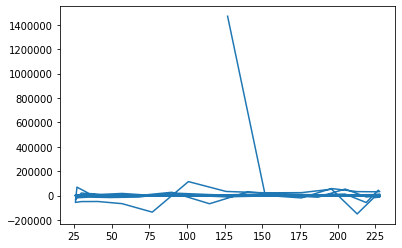

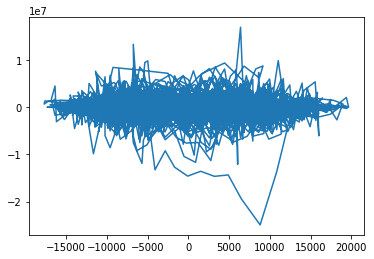

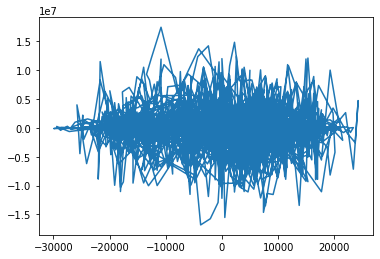

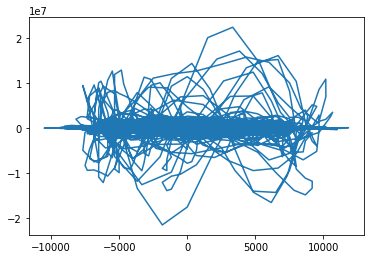

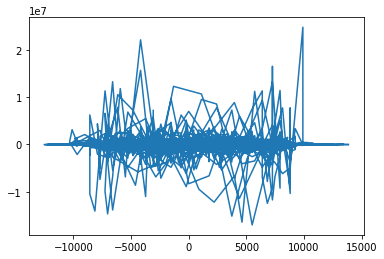

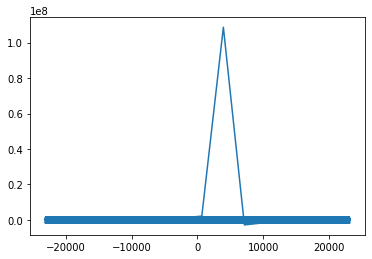

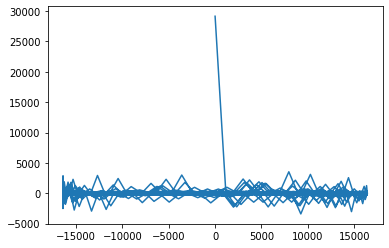




 FINISHED


<Figure size 432x288 with 0 Axes>

In [11]:
########################################
######         FFT
########################################

typechoice=input("Type 'f' for frequency and 'a' for amplitude: ")

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
plt.rcParams["font.family"] = "Times New Roman"
from scipy.io import wavfile as wav
from scipy import fftpack
import numpy.fft as fftnp
import numpy as np
import os as os
from skimage import util
from __future__ import print_function

def my_fft(wav_dir, amp_or_freq, opti=None):
    plt.ioff()
    timesNR = font_manager.findfont("Times New Roman")
    timesNR = {'fontname': timesNR}
    plt.rcParams["font.family"] = "Times New Roman"
    _,_, files = next(os.walk(wav_dir))
    
    if opti is None:
        opti = np.ndarray((len(files), 2))
        for i in range(len(files)):
            opti[i][0] = 0
            opti[i][1] = 1500

    if not os.path.exists("Fourier_Plots/"):
        os.mkdir("Fourier_Plots/")

    if os.path.exists("Fourier_Plots/Amplitude"):
        for _, _, old in os.walk("Fourier_Plots/Amplitude"):
            for file in old:
                os.remove("Fourier_Plots/Amplitude/" + str(file))
    
    if amp_or_freq == 'a':
        
        if not os.path.exists("Fourier_Plots/Amplitude/"):
            os.mkdir("Fourier_Plots/Amplitude")

        if os.path.exists("Fourier_Plots/Amplitude"):
            for _, _, old in os.walk("Fourier_Plots/Amplitude"):
                for file in old:
                    os.remove("Fourier_Plots/Amplitude/" + str(file))

        if os.path.exists(wav_dir):
            for _, _, files in os.walk(wav_dir):
                for file in files:
                    rate, data = wav.read(wav_dir + "/" + str(file))
                    fft_out = fftpack.fft(data)
                    plt.plot(data, np.abs(fft_out))
                    name = 'Fourier_Plots/Amplitude/' + str(file[ : -4])
                    x = name
                    count = 0
                    while os.path.exists(x):
                        count += 1
                        x = name + "(" + str(count) + ")"
                    plt.xlabel("Time [s]")
                    plt.ylabel("Amplitude")
                    plt.savefig(x, bbox_inches="tight")
                    plt.clf()
                    
    elif amp_or_freq == 'f':
            
            if not os.path.exists("Fourier_Plots/Frequency/"):
                os.mkdir("Fourier_Plots/Frequency")

            if os.path.exists("Fourier_Plots/Frequency"):
                for _, _, old in os.walk("Fourier_Plots/Frequency"):
                    for file in old:
                        os.remove("Fourier_Plots/Frequency/" + str(file))

            if os.path.exists(wav_dir):
                for _, _, files in os.walk(wav_dir):
                    for file, num in zip(sorted(files), range(0, len(files))):
                        rate, audio = wav.read(wav_dir + "/" + str(file))
                        
                        #Pay Tribute to https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch04.html
#                         data = np.mean(data, axis=1)
#                         N = audio.shape[0]
#                         L = N / rate
#                         print(f'Audio length: {L:.2f} seconds')
#                         f, ax = plt.subplots()
#                         ax.plot(np.arange(N) / rate, audio)
#                         ax.set_xlabel('Time [s]')
#                         ax.set_ylabel('Amplitude [unknown]')
#                         M = 1024
#                         slices = util.view_as_windows(audio, window_shape=(M, ), step=100)
#                         print(f'Audio shape: {audio.shape}, Sliced audio shape: {slices.shape}')
#                         win = np.hanning(M + 1)[:-1]
#                         slices = slices * win
#                         slices = slices.T
#                         spect = np.fft.fft(slices, axis=0)[:M // 2 + 1:-1]
#                         spect = spect.real**2 + spect.imag**2
#                         freqs = fftpack.fftfreq(len(spect)) * 30000
#                         plt.plot(freqs, np.abs(spect))
#                         plt.plot(np.fft.fft(np.abs(audio)))
            
        
                        name = 'Fourier_Plots/Frequency/' + str(file[ : -4])
                        x = name
                        count = 0
                        while os.path.exists(x):
                            count += 1
                            x = name + "(" + str(count) + ")"
                            
                        plt.title(file, **timesNR)
                        plt.xlim(opti[num][0], opti[num][1])
                        xtic = np.array([])
                        xlim = np.array([opti[num][0], opti[num][1]])
                        split = round((xlim[1] - xlim[0])/6, 5)
                        for z in range(0, 7):
                            xtic = np.append(xtic, (xlim[0] + split*z))
                        plt.xticks(xtic)
                        plt.ylabel("Amplitude [ADC counts]", **timesNR)
                        plt.xlabel("Frequency [Hz]", **timesNR)
                        plt.savefig(x, bbox_inches="tight")
                        plt.clf()


my_fft('WAVs/vibrato/', typechoice)
print('\n''\n''\n', 'FINISHED')
                        
    


/home/yvillia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


(-5, 110)

<Figure size 432x288 with 0 Axes>

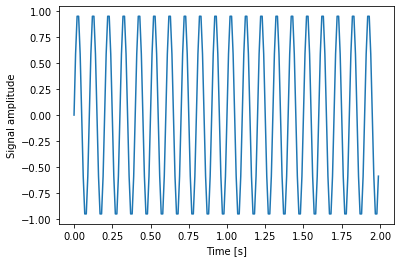

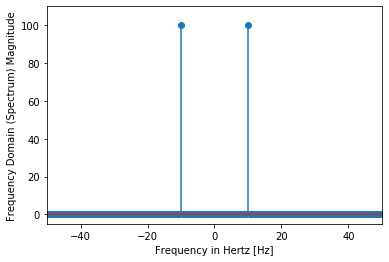

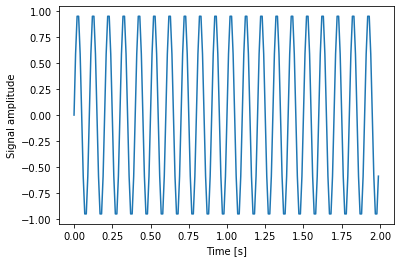

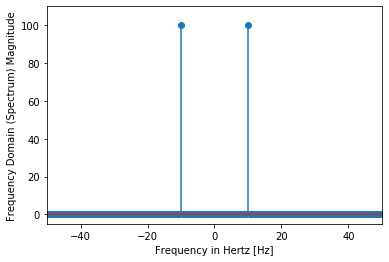

In [22]:
# f = 10  # Frequency, in cycles per second, or Hertz
# f_s = 100  # Sampling rate, or number of measurements per second

# plt.ion()
# t = np.linspace(0, 2, 2 * f_s, endpoint=False)
# x = np.sin(f * 2 * np.pi * t)

# fig, ax = plt.subplots()
# ax.plot(t, x)
# ax.set_xlabel('Time [s]')
# ax.set_ylabel('Signal amplitude')

# from scipy import fftpack

# X = fftpack.fft(x)
# freqs = fftpack.fftfreq(len(x)) * f_s

# fig, ax = plt.subplots()

# ax.stem(freqs, np.abs(X))
# ax.set_xlabel('Frequency in Hertz [Hz]')
# ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
# ax.set_xlim(-f_s / 2, f_s / 2)
# ax.set_ylim(-5, 110)

In [44]:
import matplotlib.pyplot as plt
from scipy.io import wavfile # get the api
from scipy.fftpack import fft
from pylab import *

def f(filename):
    fs, data = wavfile.read(filename) # load the data
    a = data.T # this is a two channel soundtrack, I get the first track
    b=[(ele/2**8.)*2-1 for ele in a] # this is 8-bit track, b is now normalized on [-1,1)
    c = fft(b) # create a list of complex number
    plt.plot(abs(c[0: len(c)//2]),'r')
    plt.xlim(0, 3000)
    plt.show()
#     savefig(filename+'.png',bbox_inches='tight')

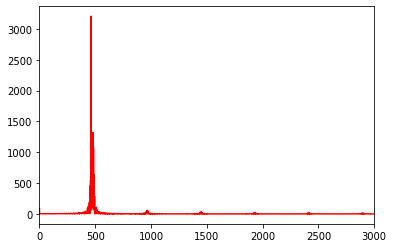

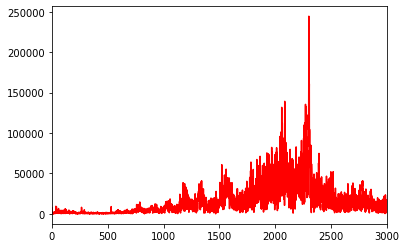

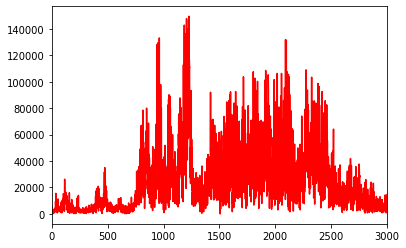

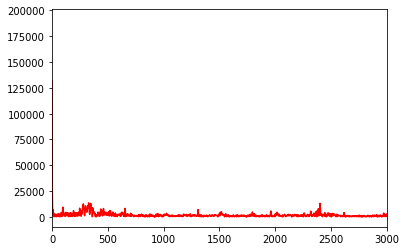

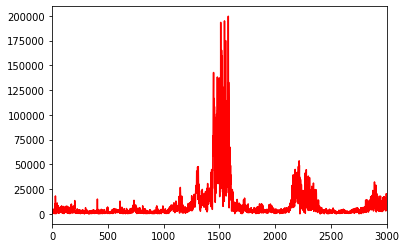

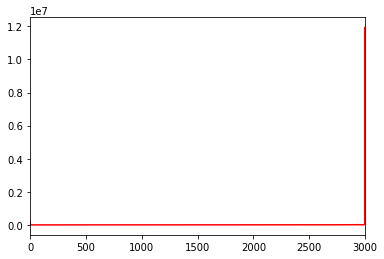

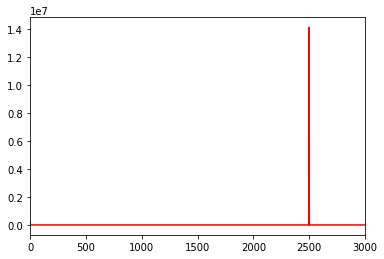

In [45]:
for _,_, files in os.walk("WAVs/vibrato/"):
    for file in sorted(files):
        f("WAVs/vibrato/" + str(file))

In [48]:
from __future__ import print_function
import scipy.io.wavfile as wavfile
import scipy
import scipy.fftpack
import numpy as np
from matplotlib import pyplot as plt

def fee(fname):
    fs_rate, signal = wavfile.read(fname)
    print ("Frequency sampling", fs_rate)
    l_audio = len(signal.shape)
    print ("Channels", l_audio)
    if l_audio == 2:
        signal = signal.sum(axis=1) / 2
    N = signal.shape[0]
    print ("Complete Samplings N", N)
    secs = N / float(fs_rate)
    print ("secs", secs)
    Ts = 1.0/fs_rate # sampling interval in time
    print ("Timestep between samples Ts", Ts)
    t = scipy.arange(0, secs, Ts) # time vector as scipy arange field / numpy.ndarray
    FFT = abs(scipy.fft(signal))
    FFT_side = FFT[range(N//2)] # one side FFT range
    freqs = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])
    fft_freqs = np.array(freqs)
    freqs_side = freqs[range(N//2)] # one side frequency range
    fft_freqs_side = np.array(freqs_side)
    plt.subplot(311)
    p1 = plt.plot(t, signal, "g") # plotting the signal
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.subplot(312)
    p2 = plt.plot(freqs, FFT, "r") # plotting the complete fft spectrum
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count dbl-sided')
    plt.subplot(313)
    p3 = plt.plot(freqs_side, abs(FFT_side), "b") # plotting the positive fft spectrum
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Count single-sided')
    plt.show()

Frequency sampling 11025
Channels 1
Complete Samplings N 11577
secs 1.0500680272108844
Timestep between samples Ts 9.070294784580499e-05


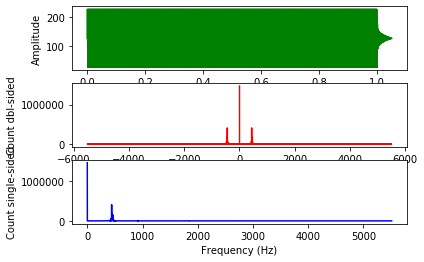

Frequency sampling 32000
Channels 1
Complete Samplings N 67427
secs 2.10709375
Timestep between samples Ts 3.125e-05


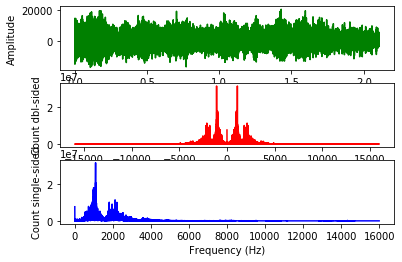

Frequency sampling 32000
Channels 1
Complete Samplings N 60289
secs 1.88403125
Timestep between samples Ts 3.125e-05


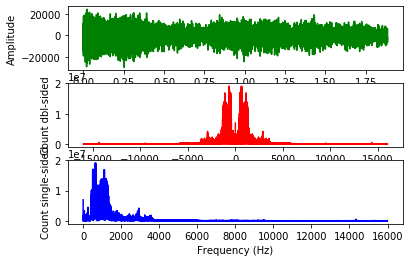

Frequency sampling 32000
Channels 1
Complete Samplings N 166052
secs 5.189125
Timestep between samples Ts 3.125e-05


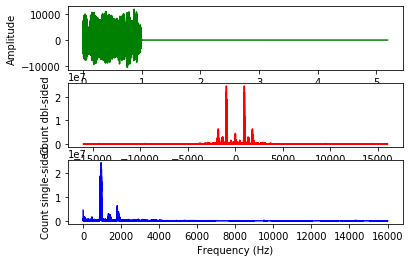

Frequency sampling 32000
Channels 1
Complete Samplings N 51555
secs 1.61109375
Timestep between samples Ts 3.125e-05


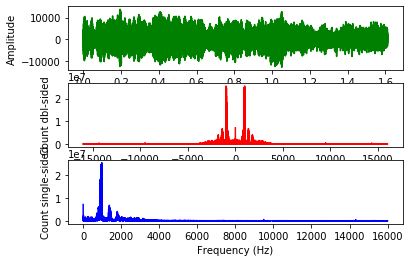

Frequency sampling 44100
Channels 1
Complete Samplings N 132301
secs 3.0000226757369615
Timestep between samples Ts 2.2675736961451248e-05


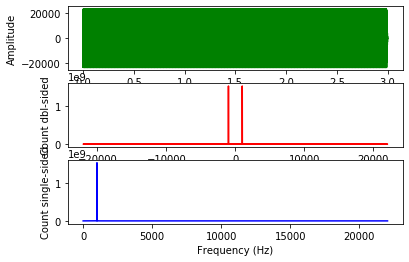

Frequency sampling 44100
Channels 1
Complete Samplings N 220500
secs 5.0
Timestep between samples Ts 2.2675736961451248e-05


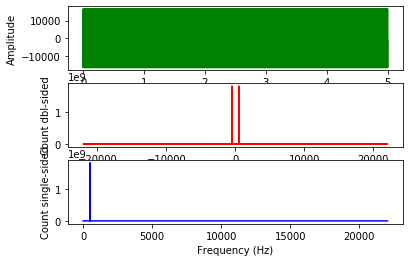

In [49]:
for _,_, files in os.walk("WAVs/vibrato/"):
    for file in sorted(files):
        fee("WAVs/vibrato/" + str(file))